# Import Necessary Library

In [ ]:
! pip install transformers

     |████████████████████████████████| 2.1MB 9.5MB/s 
     |████████████████████████████████| 3.3MB 58.8MB/s 
     |████████████████████████████████| 901kB 56.5MB/s 


In [ ]:
import json
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, Dense, \
                            TimeDistributed, LSTM, Dropout, Bidirectional, \
                            Conv1D, BatchNormalization
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from transformers import BertTokenizer, BertConfig
from transformers import TFBertForTokenClassification, AdamW

plt.style.use("tableau-colorblind10")

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('drive/MyDrive/MIT_6.862/')

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/MIT_6.862/')

In [ ]:
from metrics.ner_evaluation.ner_eval import collect_named_entities
from metrics.ner_evaluation.ner_eval import compute_metrics

# Load data and EDA

In [ ]:
data = pd.read_csv('NER_data/ner_dataset.csv', encoding="latin1")

In [ ]:
data.describe()

,Sentence #,Word,POS,Tag
count,47959,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 7244,the,NN,O
freq,1,52573,145807,887908


In [ ]:
data.dtypes

Sentence #    object
Word          object
POS           object
Tag           object
dtype: object

In [ ]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
data['Tag'].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

Text(0.5, 1.0, 'Value Counts for Tags')

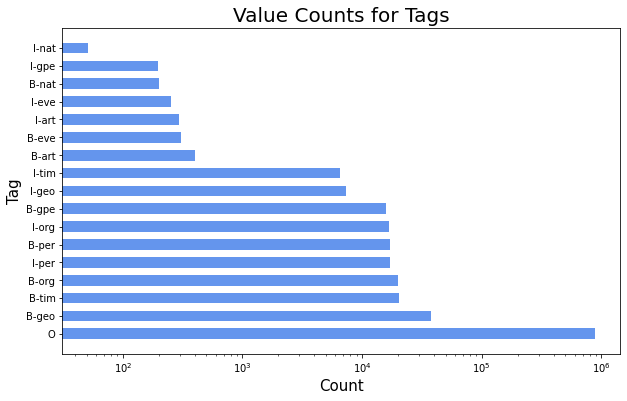

In [ ]:
value_count = data['Tag'].value_counts()
fig, axs = plt.subplots(figsize = (10, 6))
axs.barh(value_count.index, value_count, height = 0.6, color = 'cornflowerblue')
axs.set_ylabel('Tag', fontsize = 15)
axs.set_xlabel('Count', fontsize = 15)
axs.set_xscale('log')
axs.set_title('Value Counts for Tags', fontsize = 20)

In [ ]:
# fill in the empty positions in column Sentence #
sentence_sep = data['Sentence #'].isna()
for i in range(data.shape[0]):
    if sentence_sep[i]:
        data.iloc[i,0] = data.iloc[i-1,0]

In [ ]:
# save imputed dataset to csv
data.to_csv('NER_data/ner_dataset_fill.csv', index=False)

## Start to run from here!

In [ ]:
# read in imputed dataset
df = pd.read_csv('NER_data/ner_dataset_fill.csv', index_col=False, encoding="latin1")

In [ ]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [ ]:
# check if there are any NAs left
df.isna().any()

Sentence #    False
Word          False
POS           False
Tag           False
dtype: bool

In [ ]:
# Create unique word list, store the list and its length
words = sorted(df['Word'].unique())
words.append('ENDPAD')
words_size = len(words)

# Create unique tag list, store the list and its length
tags = sorted(df['Tag'].unique())
tags.append('PAD')
tags_size = len(tags)

# Create two dictionaries word:word_idx and word_idx:word
word2idx = {value: count for count, value in enumerate(words)}
idx2word = {count: value for value, count in word2idx.items()}

# Create two dictionaries tag:tag_idx and tag_idx:tag
tag2idx = {value: count for count, value in enumerate(tags)}
idx2tag = {count: value for value, count in tag2idx.items()}

In [ ]:
# create list of list where each inner list is the list of word for each sentences
# create list of list where each inner list is the list of tag for each sentences
sentence_group = df.groupby('Sentence #')
sentence_list = []
tag_list = []
count = 1
for sen in sentence_group.groups.keys():
    if count % 5000 == 0:
        print(f'iter: {count}')
    count += 1
    df_group = sentence_group.get_group(sen)
    sentence_list.append(df_group['Word'].tolist())
    tag_list.append(df_group['Tag'].tolist())

iter: 5000
iter: 10000
iter: 15000
iter: 20000
iter: 25000
iter: 30000
iter: 35000
iter: 40000
iter: 45000


In [ ]:
# pick the appropriate sentence length. Here we want to make sure that the majority of our sentences is shorter than our picked length.
# evectually we land on the 99.75% percentile.
max_length = int(np.percentile([len(sen) for sen in sentence_list], 99.75))
num_long_length = len([sen for sen in sentence_list if len(sen) > 40])
print(f'Picked max length for one sentence: {max_length}')
print(f'Number of sentences being trimmed: {num_long_length}')

Picked max length for one sentence: 50
Number of sentences being trimmed: 772


In [ ]:
# set max_length
max_length = 50

## Train Test Split

In [ ]:
# split train-test with ratio 0.1
sent_tr, sent_te, tag_tr, tag_te = train_test_split(sentence_list, tag_list, test_size=0.1, random_state=42)

# LSTM Model

## LSTM Pre-Processing

In [ ]:
# create list of list where each inner list is the list of word indices for each sentences
# create list of list where each inner list is the list of tag indices for each sentences
X_tr = []
y_tr = []
for i in range(len(sent_tr)):
    X_tr.append(list(map(word2idx.get, sent_tr[i])))
    y_tr.append(list(map(tag2idx.get, tag_tr[i])))

X_te = []
y_te = []
for i in range(len(sent_te)):
    X_te.append(list(map(word2idx.get, sent_te[i])))
    y_te.append(list(map(tag2idx.get, tag_te[i])))

In [ ]:
# pad both our X and y 
X_tr_pad = pad_sequences(sequences = X_tr, maxlen = max_length, padding = 'post', value = word2idx['ENDPAD'])
y_tr_pad = pad_sequences(sequences = y_tr, maxlen = max_length, padding = 'post', value = tag2idx["PAD"])

X_te_pad = pad_sequences(sequences = X_te, maxlen = max_length, padding = 'post', value = word2idx['ENDPAD'])
y_te_pad = pad_sequences(sequences = y_te, maxlen = max_length, padding = 'post', value = tag2idx["PAD"])

In [ ]:
# examine class imbalance in training data
s, count = np.unique(list(np.concatenate(y_tr_pad).flat), return_counts=True)
print(pd.DataFrame(count, index = tags, columns = ['Count']))

         Count
B-art      355
B-eve      272
B-geo    33836
B-gpe    14267
B-nat      179
B-org    18075
B-per    15311
B-tim    18285
I-art      257
I-eve      213
I-geo     6697
I-gpe      182
I-nat       42
I-org    15075
I-per    15584
I-tim     5931
O       798806
PAD    1214783


In [ ]:
# calculate average count per class
np.mean(count)

119897.22222222222

In [ ]:
# one hot encode our target variable
y_tr_pad = to_categorical(y_tr_pad, num_classes=tags_size)

y_te_pad = to_categorical(y_te_pad, num_classes=tags_size)

## Build Bidirectional LSTM Model

In [ ]:
# set parameters for Bidirectional LSTM
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
metrics = ['categorical_accuracy']

batch_size = 32
epochs = 20
validation_split = 0.1
verbose = 1

In [ ]:
# calculate potential class weights for loss based on class imbalance
# didn't use this part eventually
y_tr_int = np.argmax(y_tr_pad, axis=2).flatten()
class_weights = compute_class_weight('balanced', np.unique(y_tr_int), y_tr_int)
class_weights = np.asarray(class_weights)

In [ ]:
# to calculate the standard categorical cross entropy, we set the class weight to all ones
weights = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

In [ ]:
# define a custom loss function that combines class weights with categorical cross entropy loss
def custom_loss(y_true, y_pred):

  # get the first two dimensions from y_pred
  if y_pred.shape[0] is None:
    x = 1
  else:
    x = int(y_pred.shape[0])
  y = y_pred.shape[1]

  # reshape weight for each batch
  batch_weights = np.array([np.array(weights)] * (x*y))
  batch_weights = batch_weights.reshape(x,y,18)
  batch_weights = tf.cast(batch_weights, tf.float64)

  # cast y_true and y_pred into tf.float64
  y_true = tf.cast(y_true, tf.float64)
  y_pred = tf.cast(y_pred, tf.float64)

  # return weighted categorical cross entropy
  return tf.math.reduce_sum(y_true * batch_weights, axis=-1) * tf.keras.losses.categorical_crossentropy(y_true, y_pred)

In [ ]:
# Build BiLSTM model
model_title = "BiLSTM"
lstm = Sequential()
lstm.add(
    Embedding(
        input_dim = words_size, output_dim = dim_embed, input_length = max_length
    )
)
lstm.add(Dropout(drop_rate))
lstm.add(Bidirectional(LSTM(n_units, return_sequences = True)))
lstm.add(TimeDistributed(Dense(tags_size, activation = 'softmax')))

# Compile model
lstm.compile(optimizer=optimizer, loss=custom_loss, metrics=metrics)

In [ ]:
print(lstm.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
dropout (Dropout)            (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 18)            3618      
Total params: 1,883,368
Trainable params: 1,883,368
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# set early stopping for model
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto'
)

callbacks = [early_stopping]

In [ ]:
# fit the model
history = lstm.fit(X_tr_pad, y_tr_pad, batch_size=batch_size, epochs=epochs, 
                  validation_split=validation_split, callbacks=callbacks, verbose=verbose)

Epoch 1/20
1214/1214 [==============================] - 32s 12ms/step - loss: 0.3103 - categorical_accuracy: 0.9235 - val_loss: 0.0631 - val_categorical_accuracy: 0.9815
Epoch 2/20
1214/1214 [==============================] - 14s 12ms/step - loss: 0.0546 - categorical_accuracy: 0.9840 - val_loss: 0.0527 - val_categorical_accuracy: 0.9844
Epoch 3/20
1214/1214 [==============================] - 14s 12ms/step - loss: 0.0445 - categorical_accuracy: 0.9870 - val_loss: 0.0489 - val_categorical_accuracy: 0.9853
Epoch 4/20
1214/1214 [==============================] - 14s 12ms/step - loss: 0.0398 - categorical_accuracy: 0.9883 - val_loss: 0.0473 - val_categorical_accuracy: 0.9858
Epoch 5/20
1214/1214 [==============================] - 14s 11ms/step - loss: 0.0367 - categorical_accuracy: 0.9890 - val_loss: 0.0472 - val_categorical_accuracy: 0.9858
Epoch 6/20
1214/1214 [==============================] - 14s 12ms/step - loss: 0.0344 - categorical_accuracy: 0.9897 - val_loss: 0.0472 - val_categoric

## Examine Performance

In [ ]:
# Examine performance for  
lstm_pred = lstm.predict(X_te_pad, batch_size = batch_size, verbose = verbose)
lstm_pred_flat = np.argmax(lstm_pred, axis = 2).flatten()
y_te_flat = np.argmax(y_te_pad, axis = 2).flatten()

# display f1 score for each class and 
f1_lstm = f1_score(y_te_flat, lstm_pred_flat, average = None)
print(pd.DataFrame(f1_lstm, index = tags))
print('Mean F1 across classes: ',np.mean(f1_lstm))

150/150 [==============================] - 1s 3ms/step
              0
B-art  0.000000
B-eve  0.333333
B-geo  0.876239
B-gpe  0.950192
B-nat  0.230769
B-org  0.739847
B-per  0.833333
B-tim  0.900756
I-art  0.000000
I-eve  0.387097
I-geo  0.803596
I-gpe  0.720000
I-nat  0.000000
I-org  0.778735
I-per  0.865200
I-tim  0.780090
O      0.991122
PAD    0.999993
Mean F1 across classes:  0.6216834420340578


### Entity-level for LSTM

In [ ]:
lstm_pred_decode = np.argmax(lstm_pred, axis = 2)

In [ ]:
lstm_pred_tag = []
y_true_tag_lstm = []

y_true_te = np.argmax(y_te_pad, axis = 2)

for i in range(len(y_true_te)):
  lstm_pred_tag.append(list(map(idx2tag.get, lstm_pred_decode[i])))
  y_true_tag_lstm.append(list(map(idx2tag.get, y_true_te[i])))

In [ ]:
entity_tag = ['art', 'eve', 'geo', 'gpe', 'nat', 'org', 'per', 'tim']

In [ ]:
from copy import deepcopy

metrics_results = {'correct': 0, 'incorrect': 0, 'partial': 0,
                   'missed': 0, 'spurious': 0, 'possible': 0, 'actual': 0, 'precision': 0,'recall': 0,}

# overall results
results = {'strict': deepcopy(metrics_results),
           'ent_type': deepcopy(metrics_results),
           
           }

# results aggregated by entity type
evaluation_agg_entities_type_lstm = {e: deepcopy(results) for e in entity_tag}

for true_ents, pred_ents in zip(y_true_tag_lstm, lstm_pred_tag):    
    # compute results for one message
    tmp_results, tmp_agg_results = compute_metrics(collect_named_entities(true_ents),collect_named_entities(pred_ents), entity_tag)

    # aggregate overall results
    for eval_schema in results.keys():
        for metric in metrics_results.keys():
            results[eval_schema][metric] += tmp_results[eval_schema][metric]


    # aggregate results by entity type
    for e_type in entity_tag:
        for eval_schema in evaluation_agg_entities_type_lstm[e_type]:
            for metric in tmp_agg_results[e_type][eval_schema]:
                evaluation_agg_entities_type_lstm[e_type][eval_schema][metric] += tmp_agg_results[e_type][eval_schema][metric]

In [ ]:
def make_precision_recall(entity_level_dict, scheme):
  bert_entity_result = {}
  for tag in entity_level_dict.keys():
    if tag not in bert_entity_result.keys():
      bert_entity_result[tag] = {}
    bert_entity_result[tag]['precision'] = entity_level_dict[tag][scheme]['correct'] / entity_level_dict[tag][scheme]['actual'] 
    bert_entity_result[tag]['recall'] = entity_level_dict[tag][scheme]['correct'] / entity_level_dict[tag][scheme]['possible']
    if bert_entity_result[tag]['recall'] + bert_entity_result[tag]['precision'] != 0:
      bert_entity_result[tag]['f1'] = 2 * bert_entity_result[tag]['precision'] * bert_entity_result[tag]['recall'] / (bert_entity_result[tag]['recall'] + bert_entity_result[tag]['precision'])
    else:
      bert_entity_result[tag]['f1'] = 0
  return bert_entity_result

In [ ]:
f1_lstm_entity = make_precision_recall(evaluation_agg_entities_type_lstm,'strict')
f1_lstm_entity

{'art': {'f1': 0, 'precision': 0.0, 'recall': 0.0},
 'eve': {'f1': 0.01120896717373899,
  'precision': 0.005766062602965404,
  'recall': 0.2},
 'geo': {'f1': 0.7964684014869888,
  'precision': 0.712533776761588,
  'recall': 0.902818014221754},
 'gpe': {'f1': 0.6835094166283877,
  'precision': 0.5387400434467777,
  'recall': 0.9346733668341709},
 'nat': {'f1': 0.004922067268252666,
  'precision': 0.0025020850708924102,
  'recall': 0.15},
 'org': {'f1': 0.5576998818432454,
  'precision': 0.47027565592826304,
  'recall': 0.6850507982583455},
 'per': {'f1': 0.5855670103092784,
  'precision': 0.4745636836242109,
  'recall': 0.7643540669856459},
 'tim': {'f1': 0.690163281561131,
  'precision': 0.5797925727668116,
  'recall': 0.8524348253812101}}

# BERT Model

## BERT Pre-Processing and Tokenize

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

2021-05-10 01:42:46 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443
2021-05-10 01:42:47 urllib3.connectionpool DEBUG: https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/vocab.txt HTTP/1.1" 200 0
2021-05-10 01:42:47 filelock DEBUG: Attempting to acquire lock 140189487026512 on /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock
2021-05-10 01:42:47 filelock INFO: Lock 140189487026512 acquired on /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock
2021-05-10 01:42:47 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443
2021-05-10 01:42:47 urllib3.connectionpool DEBUG: https://huggingface.co:443 "GET /bert-base-cased/resolve/main/vocab.txt HTTP/1.1" 200 213450


2021-05-10 01:42:47 filelock DEBUG: Attempting to release lock 140189487026512 on /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock
2021-05-10 01:42:47 filelock INFO: Lock 140189487026512 released on /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock
2021-05-10 01:42:47 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443


2021-05-10 01:42:48 urllib3.connectionpool DEBUG: https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/added_tokens.json HTTP/1.1" 404 0
2021-05-10 01:42:48 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443
2021-05-10 01:42:48 urllib3.connectionpool DEBUG: https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/special_tokens_map.json HTTP/1.1" 404 0
2021-05-10 01:42:48 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443
2021-05-10 01:42:48 urllib3.connectionpool DEBUG: https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2021-05-10 01:42:48 filelock DEBUG: Attempting to acquire lock 140192564984144 on /root/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f.lock
2021-05-10 01:42:48 filelock INFO: Lock 140192564984144 acquired on /root/.cache/huggi

2021-05-10 01:42:48 filelock DEBUG: Attempting to release lock 140192564984144 on /root/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f.lock
2021-05-10 01:42:48 filelock INFO: Lock 140192564984144 released on /root/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f.lock
2021-05-10 01:42:48 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443


2021-05-10 01:42:48 urllib3.connectionpool DEBUG: https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/tokenizer.json HTTP/1.1" 200 0
2021-05-10 01:42:48 filelock DEBUG: Attempting to acquire lock 140189483455120 on /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6.lock
2021-05-10 01:42:48 filelock INFO: Lock 140189483455120 acquired on /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6.lock
2021-05-10 01:42:48 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443
2021-05-10 01:42:49 urllib3.connectionpool DEBUG: https://huggingface.co:443 "GET /bert-base-cased/resolve/main/tokenizer.json HTTP/1.1" 200 435797


2021-05-10 01:42:49 filelock DEBUG: Attempting to release lock 140189483455120 on /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6.lock
2021-05-10 01:42:49 filelock INFO: Lock 140189483455120 released on /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6.lock


In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
tokenized_texts_and_labels_tr = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sent_tr, tag_tr)
]

tokenized_texts_and_labels_te = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sent_te, tag_te)
]

In [ ]:
tokenized_texts_tr = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_tr]
labels_tr = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_tr]

tokenized_texts_te = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_te]
labels_te = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_te]

In [ ]:
tr_inputs = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_tr],
                          maxlen=max_length, dtype="long", value=word2idx['ENDPAD'],
                          truncating="post", padding="post")

te_inputs = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_te],
                          maxlen=max_length, dtype="long", value=word2idx['ENDPAD'],
                          truncating="post", padding="post")

In [ ]:
tr_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_tr],
                     maxlen=max_length, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

te_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_te],
                     maxlen=max_length, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
tr_masks = [[float(i != word2idx['ENDPAD']) for i in ii] for ii in tr_inputs]

te_masks = [[float(i != word2idx['ENDPAD']) for i in ii] for ii in te_inputs]

In [ ]:
tr_inputs = tf.convert_to_tensor(tr_inputs)
te_inputs = tf.convert_to_tensor(te_inputs)
tr_tags = tf.convert_to_tensor(tr_tags)
te_tags = tf.convert_to_tensor(te_tags)
tr_masks = tf.convert_to_tensor(tr_masks)
te_masks = tf.convert_to_tensor(te_masks)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices(((tr_inputs, 
                                                  tr_masks), 
                                                 tr_tags))

val_data = tf.data.Dataset.from_tensor_slices(((te_inputs, 
                                                  te_masks), 
                                               te_tags))

## BERT training

In [ ]:
BATCH_SIZE = 32
TRAIN_SHUFFLE_BUFFER_SIZE = len(tr_tags)
VAL_SHUFFLE_BUFFER_SIZE = len(te_tags)
PREFETCH_BUFFER_SIZE = 100

# Transfer training data
train_data = train_data.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
train_data = train_data.batch(batch_size=BATCH_SIZE)
train_data = train_data.prefetch(buffer_size=PREFETCH_BUFFER_SIZE)

# Transfer validation data
val_data = val_data.batch(batch_size=BATCH_SIZE)
val_data = val_data.prefetch(buffer_size=PREFETCH_BUFFER_SIZE)

print('train_data: ', train_data)
print('val_data: ', val_data)

train_data:  <PrefetchDataset shapes: (((None, 50), (None, 50)), (None, 50)), types: ((tf.int64, tf.float32), tf.int64)>
val_data:  <PrefetchDataset shapes: (((None, 50), (None, 50)), (None, 50)), types: ((tf.int64, tf.float32), tf.int64)>


In [ ]:
bert = TFBertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

2021-05-10 01:44:23 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443
2021-05-10 01:44:23 urllib3.connectionpool DEBUG: https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/config.json HTTP/1.1" 200 0
2021-05-10 01:44:23 filelock DEBUG: Attempting to acquire lock 140191205103184 on /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307.lock
2021-05-10 01:44:23 filelock INFO: Lock 140191205103184 acquired on /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307.lock
2021-05-10 01:44:23 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443
2021-05-10 01:44:24 urllib3.connectionpool DEBUG: https://huggingface.co:443 "GET /bert-base-cased/resolve/main/config.json HTTP/1.1" 200 570


2021-05-10 01:44:24 filelock DEBUG: Attempting to release lock 140191205103184 on /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307.lock
2021-05-10 01:44:24 filelock INFO: Lock 140191205103184 released on /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307.lock
2021-05-10 01:44:24 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443


2021-05-10 01:44:24 urllib3.connectionpool DEBUG: https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/tf_model.h5 HTTP/1.1" 302 0
2021-05-10 01:44:24 filelock DEBUG: Attempting to acquire lock 140189225557136 on /root/.cache/huggingface/transformers/01800f4158e284e2447020e0124bc3f6aea3ac49848e744594f7cce8ee5ac0a4.a7137b2090d9302d722735af604b4c142ec9d1bfc31be7cbbe230aea9d5cfb76.h5.lock
2021-05-10 01:44:24 filelock INFO: Lock 140189225557136 acquired on /root/.cache/huggingface/transformers/01800f4158e284e2447020e0124bc3f6aea3ac49848e744594f7cce8ee5ac0a4.a7137b2090d9302d722735af604b4c142ec9d1bfc31be7cbbe230aea9d5cfb76.h5.lock
2021-05-10 01:44:24 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): cdn-lfs.huggingface.co:443
2021-05-10 01:44:24 urllib3.connectionpool DEBUG: https://cdn-lfs.huggingface.co:443 "GET /bert-base-cased/0d04ece69d04b890153ea3bd5c2ef5706f9181495a0778a2593c6118f7ce2dc3 HTTP/1.1" 200 526681800


2021-05-10 01:44:33 filelock DEBUG: Attempting to release lock 140189225557136 on /root/.cache/huggingface/transformers/01800f4158e284e2447020e0124bc3f6aea3ac49848e744594f7cce8ee5ac0a4.a7137b2090d9302d722735af604b4c142ec9d1bfc31be7cbbe230aea9d5cfb76.h5.lock
2021-05-10 01:44:33 filelock INFO: Lock 140189225557136 released on /root/.cache/huggingface/transformers/01800f4158e284e2447020e0124bc3f6aea3ac49848e744594f7cce8ee5ac0a4.a7137b2090d9302d722735af604b4c142ec9d1bfc31be7cbbe230aea9d5cfb76.h5.lock


All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import keras
optimizer = keras.optimizers.Adam(lr=3e-5)
# Loss
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile
bert.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Callbacks
# Learning Rate Scheduler: Change learning rates during training epochs
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * 0.01
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
# Early Stopping: Stop training when a monitored metric has stopped improving
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto'
)
callbacks = [lr_scheduler,early_stopping]



In [ ]:
import time
start_time = time.time()
training_results = bert.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs, 
        callbacks=callbacks,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-05-10 01:45:06 tensorflow WARNING: AutoGraph could not transform <bound method Socket.send of <zmq.sugar.socket.Socket object at 0x7f81d8543d00>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-05-10 01:45:05 tensorflow WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
2021-05-10 01:45:07 tensorflow WARNING: AutoGraph could not transform <function wrap at 0x7f8203df0d40> and will run it as-is.
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-05-10 01:45:26 tensorflow WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2021-05-10 01:45:53 tensorflow WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-05-10 01:45:53 tensorflow WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


1349/1349 [==============================] - ETA: 0s - loss: 0.2460 - accuracy: 0.9364WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-05-10 01:50:30 tensorflow WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-05-10 01:50:30 tensorflow WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


1349/1349 [==============================] - 341s 210ms/step - loss: 0.2460 - accuracy: 0.9364 - val_loss: 0.0700 - val_accuracy: 0.9785
Epoch 2/20
1349/1349 [==============================] - 282s 209ms/step - loss: 0.0622 - accuracy: 0.9808 - val_loss: 0.0657 - val_accuracy: 0.9798
Epoch 3/20
1349/1349 [==============================] - 283s 210ms/step - loss: 0.0463 - accuracy: 0.9849 - val_loss: 0.0633 - val_accuracy: 0.9808
Epoch 4/20
1349/1349 [==============================] - 283s 210ms/step - loss: 0.0344 - accuracy: 0.9886 - val_loss: 0.0664 - val_accuracy: 0.9808
Epoch 5/20
1349/1349 [==============================] - 283s 210ms/step - loss: 0.0262 - accuracy: 0.9912 - val_loss: 0.0791 - val_accuracy: 0.9803
Epoch 6/20
1349/1349 [==============================] - 281s 208ms/step - loss: 0.0206 - accuracy: 0.9931 - val_loss: 0.0770 - val_accuracy: 0.9807
Training execution time (mins) 29.19539568424225


## Examine Performance

In [ ]:
bert_logit = bert.predict(val_data)
bert_pred_flat = bert_logit[0].argmax(axis=2).flatten()

2021-05-10 02:14:15 tensorflow WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-05-10 02:14:15 tensorflow WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


In [ ]:
f1_bert = f1_score(te_tags.numpy().flatten(), bert_pred_flat, average = None)
print(pd.DataFrame(f1_bert, index = tags))
print('Mean F1 across classes: ',np.mean(f1_bert))

              0
B-art  0.172840
B-eve  0.405797
B-geo  0.886608
B-gpe  0.945030
B-nat  0.378378
B-org  0.774257
B-per  0.850226
B-tim  0.873401
I-art  0.032258
I-eve  0.394366
I-geo  0.802319
I-gpe  0.702703
I-nat  0.545455
I-org  0.773995
I-per  0.879493
I-tim  0.786207
O      0.990377
PAD    1.000000
Mean F1 across classes:  0.6774283155062776


### Entity Level F-1 for BERT

In [ ]:
bert_pred = bert_logit[0].argmax(axis=2)

In [ ]:
bert_pred_tag = []
y_true_tag = []
y_true_te = te_tags.numpy()

for i in range(len(bert_pred)):
  bert_pred_tag.append(list(map(idx2tag.get, bert_pred[i])))
  y_true_tag.append(list(map(idx2tag.get, y_true_te[i])))

In [ ]:
entity_tag = ['art', 'eve', 'geo', 'gpe', 'nat', 'org', 'per', 'tim']

In [ ]:
from copy import deepcopy

metrics_results = {'correct': 0, 'incorrect': 0, 'partial': 0,
                   'missed': 0, 'spurious': 0, 'possible': 0, 'actual': 0, 'precision': 0,'recall': 0,}

# overall results
results = {'strict': deepcopy(metrics_results),
           'ent_type': deepcopy(metrics_results),
           
           }

# results aggregated by entity type
evaluation_agg_entities_type = {e: deepcopy(results) for e in entity_tag}

for true_ents, pred_ents in zip(y_true_tag, bert_pred_tag):    
    # compute results for one message
    tmp_results, tmp_agg_results = compute_metrics(collect_named_entities(true_ents),collect_named_entities(pred_ents), entity_tag)

    # aggregate overall results
    for eval_schema in results.keys():
        for metric in metrics_results.keys():
            results[eval_schema][metric] += tmp_results[eval_schema][metric]


    # aggregate results by entity type
    for e_type in entity_tag:
        for eval_schema in evaluation_agg_entities_type[e_type]:
            for metric in tmp_agg_results[e_type][eval_schema]:
                evaluation_agg_entities_type[e_type][eval_schema][metric] += tmp_agg_results[e_type][eval_schema][metric]

In [ ]:
f1_bert_entity = make_precision_recall(evaluation_agg_entities_type,'strict')
f1_bert_entity

{'art': {'f1': 0.018617021276595744,
  'precision': 0.009915014164305949,
  'recall': 0.15217391304347827},
 'eve': {'f1': 0.01673640167364017,
  'precision': 0.008626887131560028,
  'recall': 0.27906976744186046},
 'geo': {'f1': 0.8274886456704639,
  'precision': 0.7624862788144896,
  'recall': 0.9046068696076836},
 'gpe': {'f1': 0.6748116473223376,
  'precision': 0.5300703774792066,
  'recall': 0.9282913165266107},
 'nat': {'f1': 0.011444921316165951,
  'precision': 0.005822416302765648,
  'recall': 0.3333333333333333},
 'org': {'f1': 0.6314289107970068,
  'precision': 0.5596967782691092,
  'recall': 0.7242506811989101},
 'per': {'f1': 0.6916384014157204,
  'precision': 0.5872777360380667,
  'recall': 0.8411047345767575},
 'tim': {'f1': 0.6894952737649367,
  'precision': 0.5720627404557561,
  'recall': 0.8675942549371634}}

# BERT with Static Embedding

## BERT with Static Embedding Pre-Processing and Tokenize

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

2021-05-10 02:20:39 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443
2021-05-10 02:20:39 urllib3.connectionpool DEBUG: https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/vocab.txt HTTP/1.1" 200 0
2021-05-10 02:20:39 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443
2021-05-10 02:20:39 urllib3.connectionpool DEBUG: https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/added_tokens.json HTTP/1.1" 404 0
2021-05-10 02:20:39 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443
2021-05-10 02:20:40 urllib3.connectionpool DEBUG: https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/special_tokens_map.json HTTP/1.1" 404 0
2021-05-10 02:20:40 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443
2021-05-10 02:20:40 urllib3.connectionpool DEBUG: https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/tokenizer_config.json HTTP/1.1" 

In [ ]:
def tokenize_and_preserve_labels_embed(sentence, text_labels):
    tokenized_sentence = []
    extended_words = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the extended word to the corresponding word list
        extended_words.extend([word.lower()] * n_subwords)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, extended_words, labels

In [ ]:
tokenized_texts_and_labels_tr_embed = [
    tokenize_and_preserve_labels_embed(sent, labs)
    for sent, labs in zip(sent_tr, tag_tr)
]

tokenized_texts_and_labels_te_embed = [
    tokenize_and_preserve_labels_embed(sent, labs)
    for sent, labs in zip(sent_te, tag_te)
]

In [ ]:
tokenized_texts_tr_embed = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_tr_embed]
extended_words_tr_embed = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_tr_embed]
labels_tr_embed = [token_label_pair[2] for token_label_pair in tokenized_texts_and_labels_tr_embed]

tokenized_texts_te_embed = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_te_embed]
extended_words_te_embed = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_te_embed]
labels_te_embed = [token_label_pair[2] for token_label_pair in tokenized_texts_and_labels_te_embed]

In [ ]:
tr_inputs_embed = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_tr],
                          maxlen=max_length, dtype="long", value=word2idx['ENDPAD'],
                          truncating="post", padding="post")

te_inputs_embed = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_te],
                          maxlen=max_length, dtype="long", value=word2idx['ENDPAD'],
                          truncating="post", padding="post")

In [ ]:
tr_tags_embed = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_tr],
                     maxlen=max_length, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

te_tags_embed = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_te],
                     maxlen=max_length, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
tr_masks_embed = [[float(i != word2idx['ENDPAD']) for i in ii] for ii in tr_inputs_embed]

te_masks_embed = [[float(i != word2idx['ENDPAD']) for i in ii] for ii in te_inputs_embed]

In [ ]:
tr_inputs_embed = tf.convert_to_tensor(tr_inputs_embed)
te_inputs_embed = tf.convert_to_tensor(te_inputs_embed)
tr_tags_embed = tf.convert_to_tensor(tr_tags_embed)
te_tags_embed = tf.convert_to_tensor(te_tags_embed)
tr_masks_embed = tf.convert_to_tensor(tr_masks_embed)
te_masks_embed = tf.convert_to_tensor(te_masks_embed)

In [ ]:
vocab_tr = [w for s in extended_words_tr_embed for w in s]
vocab_te = [w for s in extended_words_te_embed for w in s]
vocab = sorted(list(set(vocab_tr + vocab_te)))
vocab.append('ENDPAD')
vocab_size = len(vocab)

# Create two dictionaries word:word_idx and word_idx:word
word2idx_lower = {value: count for count, value in enumerate(vocab)}
idx2word_lower = {count: value for value, count in word2idx_lower.items()}

In [ ]:
# create list of list where each inner list is the list of word indices for each sentences
# create list of list where each inner list is the list of tag indices for each sentences
X_tr_lower = []
# y_tr = []
for i in range(len(extended_words_tr_embed)):
    X_tr_lower.append(list(map(word2idx_lower.get, extended_words_tr_embed[i])))

X_te_lower = []
for i in range(len(extended_words_te_embed)):
    X_te_lower.append(list(map(word2idx_lower.get, extended_words_te_embed[i])))

In [ ]:
# pad both our X and y 
X_tr_pad_lower = pad_sequences(sequences = X_tr_lower, maxlen = max_length, truncating="post", padding = 'post', value = word2idx_lower['ENDPAD'])
X_te_pad_lower = pad_sequences(sequences = X_te_lower, maxlen = max_length, truncating="post", padding = 'post', value = word2idx_lower['ENDPAD'])

In [ ]:
X_tr_lower_tf = tf.convert_to_tensor(X_tr_pad_lower)
X_te_lower_tf = tf.convert_to_tensor(X_te_pad_lower)

In [ ]:
train_data_embed = tf.data.Dataset.from_tensor_slices(((X_tr_lower_tf, 
                                                        tr_inputs_embed,
                                                        tr_masks_embed), 
                                                       tr_tags_embed))

val_data_embed = tf.data.Dataset.from_tensor_slices(((X_te_lower_tf, 
                                                      te_inputs_embed,
                                                      te_masks_embed),
                                                     te_tags_embed))

In [ ]:
BATCH_SIZE = 32
TRAIN_SHUFFLE_BUFFER_SIZE = len(X_tr_pad_lower)
VAL_SHUFFLE_BUFFER_SIZE = len(te_tags)
PREFETCH_BUFFER_SIZE = 100

# Transfer training data
train_data_embed = train_data_embed.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
train_data_embed = train_data_embed.batch(batch_size=BATCH_SIZE)
train_data_embed = train_data_embed.prefetch(buffer_size=PREFETCH_BUFFER_SIZE)

# Transfer validation data
val_data_embed = val_data_embed.batch(batch_size=BATCH_SIZE)
val_data_embed = val_data_embed.prefetch(buffer_size=PREFETCH_BUFFER_SIZE)

print('train_data: ', train_data_embed)
print('val_data: ', val_data_embed)

train_data:  <PrefetchDataset shapes: (((None, 50), (None, 50), (None, 50)), (None, 50)), types: ((tf.int32, tf.int64, tf.float32), tf.int64)>
val_data:  <PrefetchDataset shapes: (((None, 50), (None, 50), (None, 50)), (None, 50)), types: ((tf.int32, tf.int64, tf.float32), tf.int64)>


## Loading Pre-trained GloVe Embedding

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [ ]:
path_to_glove_file = "./glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
num_tokens = vocab_size
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word2idx_lower.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 28807 words (3011 misses)


## Model Construction and Training

In [ ]:
max_length = 50

In [ ]:
import keras
from tensorflow.keras.layers import Input, Embedding, Dense, \
                            TimeDistributed, LSTM, Dropout, Bidirectional, \
                            Conv1D, BatchNormalization, GlobalMaxPooling1D, \
                            Concatenate, Flatten

In [ ]:
def combined_model():
    embed_model = Sequential()
    embed_model.add(Embedding(vocab_size, embedding_dim, input_length = 50, 
                             embeddings_initializer=keras.initializers.Constant(embedding_matrix), 
                             trainable=False, 
                             name = "embedding"))
    embed_model.add(Conv1D(128, 5, padding='same', activation="relu"))
    
    embed_input = Input(shape = (max_length, ), name = 'embed_input')
    embed_output = embed_model(embed_input)
    
    input_ids = Input(shape = (max_length,), dtype='int64', name = 'id_input')
    token_type_ids = Input(shape = (max_length,), dtype='int64', name = 'token_input')
    
    bert_embed = bert.layers[0]
    bert_embed.trainable = False
    bert_output = bert_embed([input_ids, token_type_ids]).last_hidden_state

    concat = Concatenate()([embed_output, bert_output])
    concat = Dense(768, activation='relu', name = 'merge_dense2')(concat)
    concat = Dropout(0.2, name = 'merge_dropout2')(concat)
    final_model_output = bert.layers[2](concat)
    final_model = Model(inputs=[embed_input, input_ids, token_type_ids], outputs=final_model_output)
    return final_model


In [ ]:
bert_with_embed = combined_model()

In [ ]:
bert_with_embed.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embed_input (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
id_input (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50, 128)      3245928     embed_input[0][0]                
______________________________________________________________________________________________

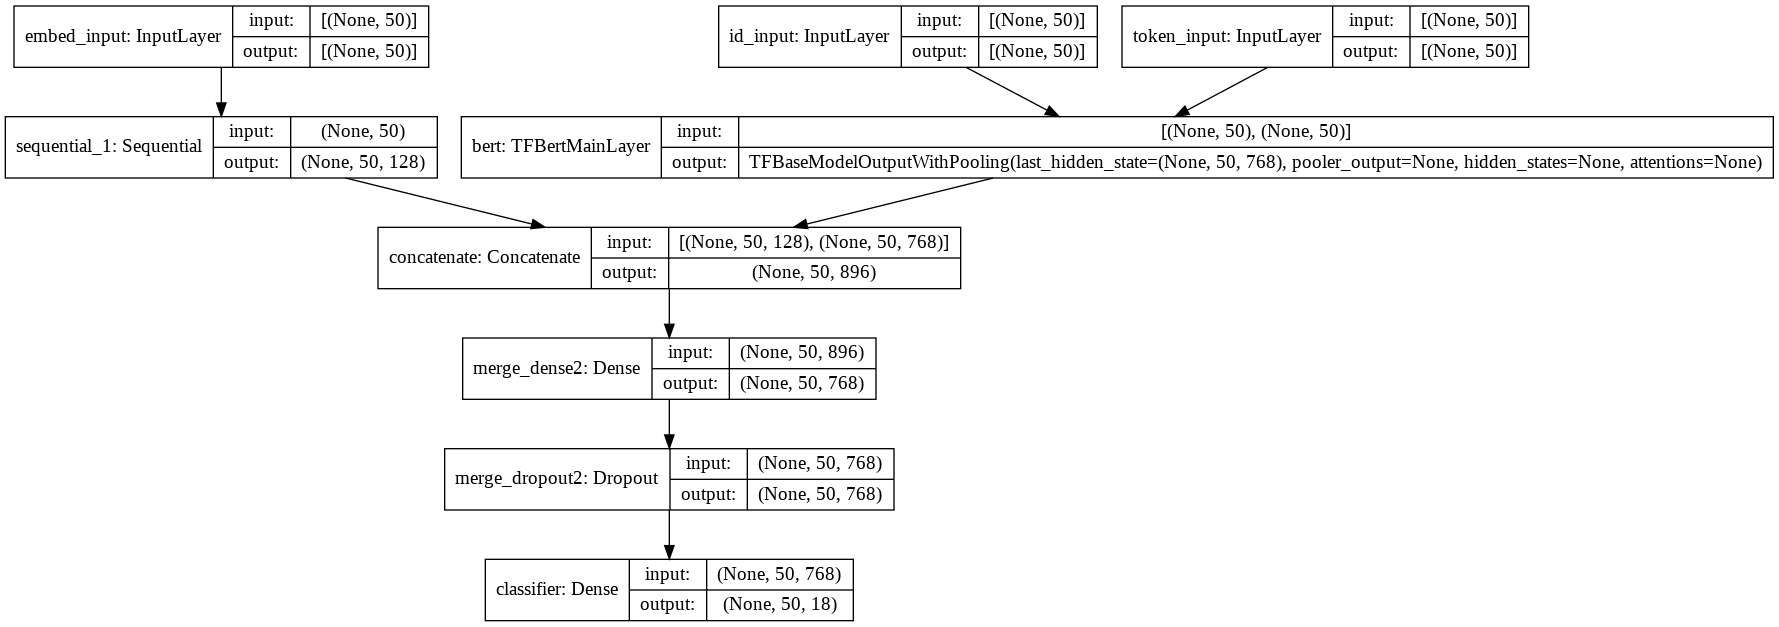

In [ ]:
from keras.utils import plot_model
plot_model(bert_with_embed, show_shapes=True)

In [ ]:
import keras
epochs = 10
optimizer = keras.optimizers.Adam(lr=3e-5)
# Loss
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile
bert_with_embed.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Callbacks
# Learning Rate Scheduler: Change learning rates during training epochs
def scheduler(epoch, lr):
  if epoch < 1:
    return lr
  else:
    return lr * 0.5
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
# Early Stopping: Stop training when a monitored metric has stopped improving
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto'
)
callbacks = [lr_scheduler,early_stopping]



In [ ]:
import time
start_time = time.time()
training_results = bert_with_embed.fit(
        train_data_embed,
        validation_data=val_data_embed,
        epochs=epochs, 
        callbacks=callbacks,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Epoch 1/10
1349/1349 [==============================] - 134s 91ms/step - loss: 0.3277 - accuracy: 0.9391 - val_loss: 0.0765 - val_accuracy: 0.9809
Epoch 2/10
1349/1349 [==============================] - 120s 89ms/step - loss: 0.0176 - accuracy: 0.9945 - val_loss: 0.0804 - val_accuracy: 0.9810
Epoch 3/10
1349/1349 [==============================] - 119s 88ms/step - loss: 0.0166 - accuracy: 0.9947 - val_loss: 0.0830 - val_accuracy: 0.9810
Epoch 4/10
1349/1349 [==============================] - 120s 89ms/step - loss: 0.0155 - accuracy: 0.9950 - val_loss: 0.0838 - val_accuracy: 0.9811
Training execution time (mins) 8.21431381702423


In [ ]:
# save weights
model_name = 'BERT_embed'
save_path = model_name + '.h5'
bert.save_weights(save_path)

## Examine Performance

In [ ]:
bert_logit_embed = bert_with_embed.predict(val_data_embed)
bert_pred_flat_embed = bert_logit_embed.argmax(axis=2).flatten()

In [ ]:
f1_bert_embed = f1_score(te_tags_embed.numpy().flatten(), bert_pred_flat_embed, average = None)
embed_df = pd.DataFrame(f1_bert_embed, index = tags)
print(embed_df)
print('Mean F1 across classes: ',np.mean(embed_df))

              0
B-art  0.172185
B-eve  0.363636
B-geo  0.888427
B-gpe  0.945248
B-nat  0.258065
B-org  0.770255
B-per  0.848304
B-tim  0.885753
I-art  0.000000
I-eve  0.393443
I-geo  0.797945
I-gpe  0.705882
I-nat  0.000000
I-org  0.773340
I-per  0.889193
I-tim  0.785208
O      0.990730
PAD    1.000000
Mean F1 across classes:  0    0.63709
dtype: float64


### Entity Level F-1 for BERT with static embedding

In [ ]:
bert_pred_embed = bert_logit_embed.argmax(axis=2)

In [ ]:
bert_pred_tag_embed = []
y_true_tag_embed = []
y_true_te_embed = te_tags_embed.numpy()

for i in range(len(bert_pred_embed)):
  bert_pred_tag_embed.append(list(map(idx2tag.get, bert_pred_embed[i])))
  y_true_tag_embed.append(list(map(idx2tag.get, y_true_te_embed[i])))

In [ ]:
entity_tag = ['art', 'eve', 'geo', 'gpe', 'nat', 'org', 'per', 'tim']

In [ ]:
from copy import deepcopy

metrics_results_embed = {'correct': 0, 'incorrect': 0, 'partial': 0,
                   'missed': 0, 'spurious': 0, 'possible': 0, 'actual': 0, 'precision': 0,'recall': 0,}

# overall results
results_embed = {'strict': deepcopy(metrics_results_embed),
           'ent_type': deepcopy(metrics_results_embed),
           
           }

# results aggregated by entity type
evaluation_agg_entities_type_embed = {e: deepcopy(results_embed) for e in entity_tag}

for true_ents, pred_ents in zip(y_true_tag_embed, bert_pred_tag_embed):    
    # compute results for one message
    tmp_results_embed, tmp_agg_results_embed = compute_metrics(collect_named_entities(true_ents),collect_named_entities(pred_ents), entity_tag)

    # aggregate overall results
    for eval_schema in results_embed.keys():
        for metric in metrics_results_embed.keys():
            results_embed[eval_schema][metric] += tmp_results_embed[eval_schema][metric]


    # aggregate results by entity type
    for e_type in entity_tag:
        for eval_schema in evaluation_agg_entities_type_embed[e_type]:
            for metric in tmp_agg_results_embed[e_type][eval_schema]:
                evaluation_agg_entities_type_embed[e_type][eval_schema][metric] += tmp_agg_results_embed[e_type][eval_schema][metric]

In [ ]:
f1_bert_entity_embed = make_precision_recall(evaluation_agg_entities_type_embed,'strict')
f1_bert_entity_embed

{'art': {'f1': 0.01760821716801174,
  'precision': 0.00944138473642801,
  'recall': 0.13043478260869565},
 'eve': {'f1': 0.017054263565891473,
  'precision': 0.008821170809943865,
  'recall': 0.2558139534883721},
 'geo': {'f1': 0.8346883468834689,
  'precision': 0.7763618540820614,
  'recall': 0.9024906397525639},
 'gpe': {'f1': 0.6972553949298136,
  'precision': 0.5568942436412316,
  'recall': 0.9322128851540616},
 'nat': {'f1': 0.004792332268370607,
  'precision': 0.0024429967426710096,
  'recall': 0.125},
 'org': {'f1': 0.6390877107849084,
  'precision': 0.5759895036081347,
  'recall': 0.7177111716621254},
 'per': {'f1': 0.7019827455728772,
  'precision': 0.6070680628272251,
  'recall': 0.8320775026910656},
 'tim': {'f1': 0.7075004584632314,
  'precision': 0.598139534883721,
  'recall': 0.8657989228007181}}

# Model Comparison

Need to rerun lstm, bert, bert with static embedding

In [ ]:
f1_word_level = {}

# Baseline model
f1_word_level['Bi-LSTM'] = f1_lstm
f1_word_level['BERT'] = f1_bert
f1_word_level['BERT_embed'] = f1_bert_embed

In [ ]:
df_word_metric = pd.DataFrame(f1_word_level)

In [ ]:
df_word_metric

,Bi-LSTM,BERT,BERT_embed
0,0.000000,0.172840,0.172185
1,0.333333,0.405797,0.363636
2,0.876239,0.886608,0.888427
3,0.950192,0.945030,0.945248
4,0.230769,0.378378,0.258065
5,0.739847,0.774257,0.770255
6,0.833333,0.850226,0.848304
7,0.900756,0.873401,0.885753
8,0.000000,0.032258,0.000000
9,0.387097,0.394366,0.393443


In [ ]:
import numpy as np

In [ ]:
(0.172185 + 0.363636 + 0.888427 + 0.945248 + 0.258065 + 0.770255 + 0.848304 + 0.885753 + 0.000000 + 0.393443 + 0.797945 + 0.705882 + 0.000000 + 0.773340 + 0.889193 + 0.785208 + 0.990730 + 1.000000) / 18

0.6370896666666668

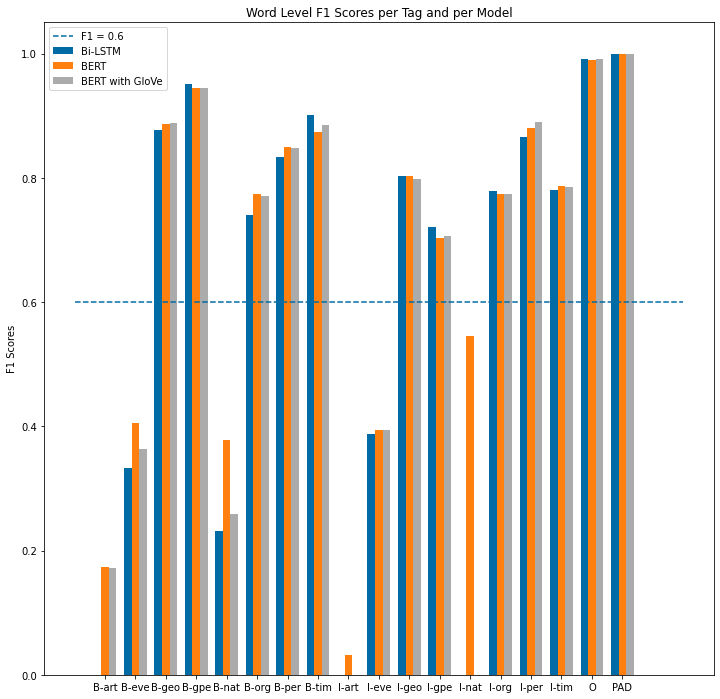

In [ ]:
labels = list(idx2tag.values())

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12,12))
rects1 = ax.bar(x - width, f1_word_level['Bi-LSTM'], width, label = 'Bi-LSTM')
rects2 = ax.bar(x, f1_word_level['BERT'], width, label = 'BERT')
rects3 = ax.bar(x + width, f1_word_level['BERT_embed'], width, label = 'BERT with GloVe')

ax.plot(np.arange(-1, 20, step = 1), [0.6] * 21, '--', label = 'F1 = 0.6')

ax.set_ylabel('F1 Scores')
ax.set_title('Word Level F1 Scores per Tag and per Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.savefig('wrd_f1.png')
plt.show()

In [ ]:
f1_entity_level = {}

f1_lstm_entity_list = []
f1_bert_entity_list = []
f1_bert_embed_entity_list = []

for key in f1_lstm_entity.keys():
  f1_lstm_entity_list.append(f1_lstm_entity[key]['f1'])
  f1_bert_entity_list.append(f1_bert_entity[key]['f1'])
  f1_bert_embed_entity_list.append(f1_bert_entity_embed[key]['f1'])


# Baseline model
f1_entity_level['Bi-LSTM'] = f1_lstm_entity_list
f1_entity_level['BERT'] = f1_bert_entity_list
f1_entity_level['BERT_embed'] = f1_bert_embed_entity_list

In [ ]:
df_entry_metric = pd.DataFrame(f1_entity_level)

In [ ]:
df_entry_metric

,Bi-LSTM,BERT,BERT_embed
0,0.000000,0.018617,0.017608
1,0.011209,0.016736,0.017054
2,0.796468,0.827489,0.834688
3,0.683509,0.674812,0.697255
4,0.004922,0.011445,0.004792
5,0.557700,0.631429,0.639088
6,0.585567,0.691638,0.701983
7,0.690163,0.689495,0.707500


In [ ]:
np.mean(f1_lstm_entity_list)

0.4161923782838779

In [ ]:
np.mean(f1_bert_entity_list)

0.4452076529046084

In [ ]:
np.mean(f1_bert_embed_entity_list)

0.4524961837045717

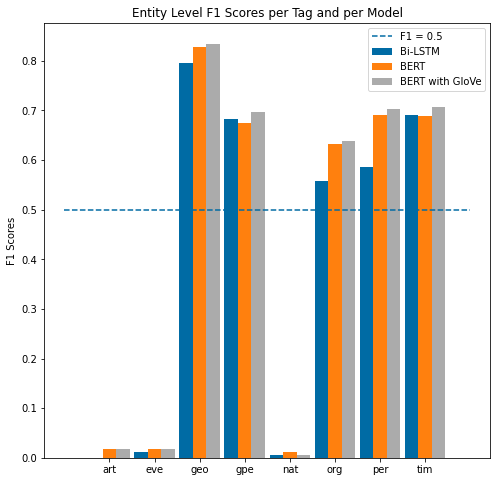

In [ ]:
entity_tag = ['art', 'eve', 'geo', 'gpe', 'nat', 'org', 'per', 'tim']

x = np.arange(len(entity_tag))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(8,8))
rects1 = ax.bar(x - width, f1_entity_level['Bi-LSTM'], width, label = 'Bi-LSTM')
rects2 = ax.bar(x, f1_entity_level['BERT'], width, label = 'BERT')
rects3 = ax.bar(x + width, f1_entity_level['BERT_embed'], width, label = 'BERT with GloVe')

ax.plot(np.arange(-1, 9, step = 1), [0.5] * 10, '--', label = 'F1 = 0.5')

ax.set_ylabel('F1 Scores')
ax.set_title('Entity Level F1 Scores per Tag and per Model')
ax.set_xticks(x)
ax.set_xticklabels(entity_tag)
ax.legend()
plt.savefig('ent_f1.png')
plt.show()

# LUKE

## Load and Preprocess 

In [ ]:
!pip install seqeval git+https://github.com/huggingface/transformers.git

In [ ]:
from transformers import LukeTokenizer, LukeForEntitySpanClassification
from tqdm import notebook, trange
import unicodedata
import torch
import seqeval.metrics
import spacy

In [ ]:
luke_model = LukeForEntitySpanClassification.from_pretrained("studio-ousia/luke-large-finetuned-conll-2003")
# luke_model.eval()
luke_model.train()

# Load the tokenizer
luke_tokenizer = LukeTokenizer.from_pretrained("studio-ousia/luke-large-finetuned-conll-2003")

In [ ]:
luke_model.classifier = torch.nn.Linear(in_features = 3072, out_features = 18, bias = True)
# luke_model.classifier = torch.nn.Linear(in_features = 50, out_features = 18, bias = True)
luke_model.config.label2id = tag2idx
luke_model.config.id2label = idx2tag


class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.fc1 = luke_model
        self.out = torch.nn.Linear(50, 18)
        
    def forward(self, input_ids: torch.LongTensor,
        entity_ids: torch.LongTensor,
        entity_position_ids: torch.LongTensor,
        entity_start_positions: torch.LongTensor,
        entity_end_positions: torch.LongTensor,
        attention_mask: torch.LongTensor,
        entity_attention_mask: torch.LongTensor):
        x = self.fc1(input_ids, entity_ids, entity_position_ids, entity_start_positions, entity_end_positions, attention_mask, entity_attention_mask)
        x = self.out(x)
        return x

luke_model_full = MyModel()
# luke_model_full = torch.nn.Sequential(
#     luke_model,
#     torch.nn.Linear(in_features = 50, out_features = 18, bias = True)
# )
# luke_model.to("cuda")

In [ ]:
luke_model.to("cuda")

In [ ]:
# This and the following code blocks are originally from LUKE's official github

def load_document(documents):
    examples = []
    max_token_length = max_length
    max_mention_length = 30

    round = 0
    for document in notebook.tqdm(documents):
        #print(document)
        round += 1
        #print("round is ",round)
        words = document["words"]
        # subword = [luke_tokenizer.tokenize(w) for w in words]
        subword_lengths = [len(luke_tokenizer.tokenize(w)) for w in words]
        #print('subword is ',subword)
        #print('subword_lengths is ',subword_lengths)
        total_subword_length = sum(subword_lengths)
        #print('total_subword_length is ', total_subword_length)
        sentence_boundaries = document["sentence_boundaries"]

        # for i in range(len(sentence_boundaries) - 1):
        sentence_start, sentence_end = sentence_boundaries
        if total_subword_length <= max_token_length:
            # if the total sequence length of the document is shorter than the
            # maximum token length, we simply use all words to build the sequence
            context_start = 0
            context_end = len(words)
        else:
            # if the total sequence length is longer than the maximum length, we add
            # the surrounding words of the target sentence　to the sequence until it
            # reaches the maximum length
            context_start = sentence_start
            context_end = max_token_length
            # cur_length = sum(subword_lengths[context_start:context_end])
            # print('cur_length is ', cur_length)
            # while True:
                # if context_start > 0:
                #     print('context_start > 0 and context_start is ', context_start)
                #     if cur_length + subword_lengths[context_start - 1] <= max_token_length:
                #         cur_length += subword_lengths[context_start - 1]
                #         context_start -= 1
                #     else:
                #         break
                # if context_end < len(words):
                #     print('context_end < len(words)')
                #     if cur_length + subword_lengths[context_end] <= max_token_length:
                #         print(cur_length + subword_lengths[context_end])
                #         cur_length += subword_lengths[context_end]
                #         context_end += 1
                #     else:
                #         break

        text = ""
        for word in words[context_start:sentence_start]:
            if word[0] == "'" or (len(word) == 1 and is_punctuation(word)):
                text = text.rstrip()
            text += word
            text += " "

        sentence_words = words[sentence_start:sentence_end]
        sentence_subword_lengths = subword_lengths[sentence_start:sentence_end]

        word_start_char_positions = []
        word_end_char_positions = []
        for word in sentence_words:
            if word[0] == "'" or (len(word) == 1 and is_punctuation(word)):
                text = text.rstrip()
            word_start_char_positions.append(len(text))
            text += word
            word_end_char_positions.append(len(text))
            text += " "

        for word in words[sentence_end:context_end]:
            if word[0] == "'" or (len(word) == 1 and is_punctuation(word)):
                text = text.rstrip()
            text += word
            text += " "
        text = text.rstrip()

        entity_spans = []
        original_word_spans = []
        for word_start in range(len(sentence_words)):
            for word_end in range(word_start, len(sentence_words)):
                if sum(sentence_subword_lengths[word_start:word_end]) <= max_mention_length:
                    entity_spans.append(
                        (word_start_char_positions[word_start], word_end_char_positions[word_end])
                    )
                    original_word_spans.append(
                        (word_start, word_end + 1)
                    )

        examples.append(dict(
            text=text,
            words=sentence_words,
            entity_spans=entity_spans,
            original_word_spans=original_word_spans,
        ))

    return examples


def is_punctuation(char):
    cp = ord(char)
    if (cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126):
        return True
    cat = unicodedata.category(char)
    if cat.startswith("P"):
        return True
    return False

In [ ]:
train_data = load_document(train_documents)

In [ ]:
test_data = load_document(test_documents)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
batch_size = 32
all_logits = []
luke_optimizer = AdamW(luke_model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

for batch_start_idx in trange(0, len(train_data), batch_size):
    # print(batch_start_idx)
    batch_examples = train_data[batch_start_idx:batch_start_idx + batch_size]
    texts = [example["text"] for example in batch_examples]
    entity_spans = [example["entity_spans"] for example in batch_examples]
    batch_target = train_documents[batch_start_idx:batch_start_idx + batch_size]
    targets_label = [target["labels"] for target in batch_target]
    targets = []
    for l in targets_label:
        target_holder = []
        for k in range(len(l)):
            # print(luke_model.config.label2id[l[k]])
            target_holder.append(luke_model.config.label2id[l[k]])
        targets.append(target_holder)

    inputs = luke_tokenizer(texts, entity_spans=entity_spans, return_tensors="pt", padding='max_length', truncation=True,  max_length = 32)
    # inputs_toy = luke_tokenizer(texts, entity_spans=entity_spans, return_tensors="pt", padding='max_length', truncation=True,  max_length = 50, return_length=True)
    # print(inputs_toy['length'])
    # print(inputs)
    inputs = inputs.to("cuda")
    with torch.no_grad():
        outputs = luke_model_full(**inputs)
    all_logits.extend(outputs.logits.tolist())
    print(outputs.logits.shape)
    # loss = loss_fn(, targets)
    # loss.backward()
    # luke_optimizer.step()
    del outputs
    torch.cuda.empty_cache()
print(all_logits)

In [ ]:
final_labels = [label for document in train_documents for label in document["labels"]]

final_predictions = []
for example_index, example in enumerate(train_data):
    logits = all_logits[example_index]
    max_logits = np.max(logits, axis=1)
    max_indices = np.argmax(logits, axis=1)
    original_spans = example["original_word_spans"]
    predictions = []
    for logit, index, span in zip(max_logits, max_indices, original_spans):
        if index != 0:  # the span is not NIL
            predictions.append((logit, span, luke_model.config.id2label[index]))

    # construct an IOB2 label sequence
    predicted_sequence = ["O"] * len(example["words"])
    for _, span, label in sorted(predictions, key=lambda o: o[0], reverse=True):
        if all([o == "O" for o in predicted_sequence[span[0] : span[1]]]):
            predicted_sequence[span[0]] = "B-" + label
            if span[1] - span[0] > 1:
                predicted_sequence[span[0] + 1 : span[1]] = ["I-" + label] * (span[1] - span[0] - 1)

    final_predictions += predicted_sequence

In [ ]:
print('Training Performance')
print(seqeval.metrics.classification_report([final_labels], [final_predictions], digits=4))

In [ ]:
# check cuda storage

def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)
dump_tensors()